# Lung Cancer Detection Using CNNs

### Import libraries for data imports

In [1]:
import dicom
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2
from sklearn.utils import shuffle
import tensorflow as tf

def show_img(image):
    plt.imshow(image)
    plt.show()

/Users/satchelgrant/miniconda3/envs/obama/lib/python3.5/site-packages/dicom/__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)


### Import and Convert Data

In [2]:
path = './sample_images/'
dcmFiles = []
for dirName, subDirList, fileList in os.walk(path):
    for fileName in fileList:
        if '.dcm' in fileName.lower():
            dcmFiles.append(os.path.join(dirName,fileName))
            
id_labels = dict()
with open('stage1_labels.csv', 'r') as labelFile:
    for i,line in enumerate(labelFile):
        if i == 0: continue
        p_id, cancer = line.strip().split(',')
        id_labels[p_id] = int(cancer)


In [3]:
def convert_images(id_labels, dFiles):
    labeless_images = []
    labeled_images = []
    labels = []
    for file in dFiles:
        ref = dicom.read_file(file)
        p_id = ref.PatientID
        if p_id in id_labels:
            labeled_images.append(ref.pixel_array)
            labels.append(id_labels[p_id])
        else:
            labeless_images.append(ref.pixel_array)
    return np.array(labeled_images, dtype=np.float32), np.array(labels), np.array(labeless_images, dtype=np.float32)


In [4]:
labeled_data, data_labels, labeless_data = convert_images(id_labels, dcmFiles)
print("Labeled Data Shape (n_samples,rowpix,colpix): " + str(labeled_data.shape))
print("Unlabeled Data Shape (n_samples,rowpix,colpix): " + str(labeless_data.shape))
img_shape = (labeled_data.shape[1], labeled_data.shape[2])
print("Initial Image Shape: " + str(img_shape))


Labeled Data Shape (n_samples,rowpix,colpix): (3408, 512, 512)
Unlabeled Data Shape (n_samples,rowpix,colpix): (196, 512, 512)
Initial Image Shape: (512, 512)


### Visualization of Images

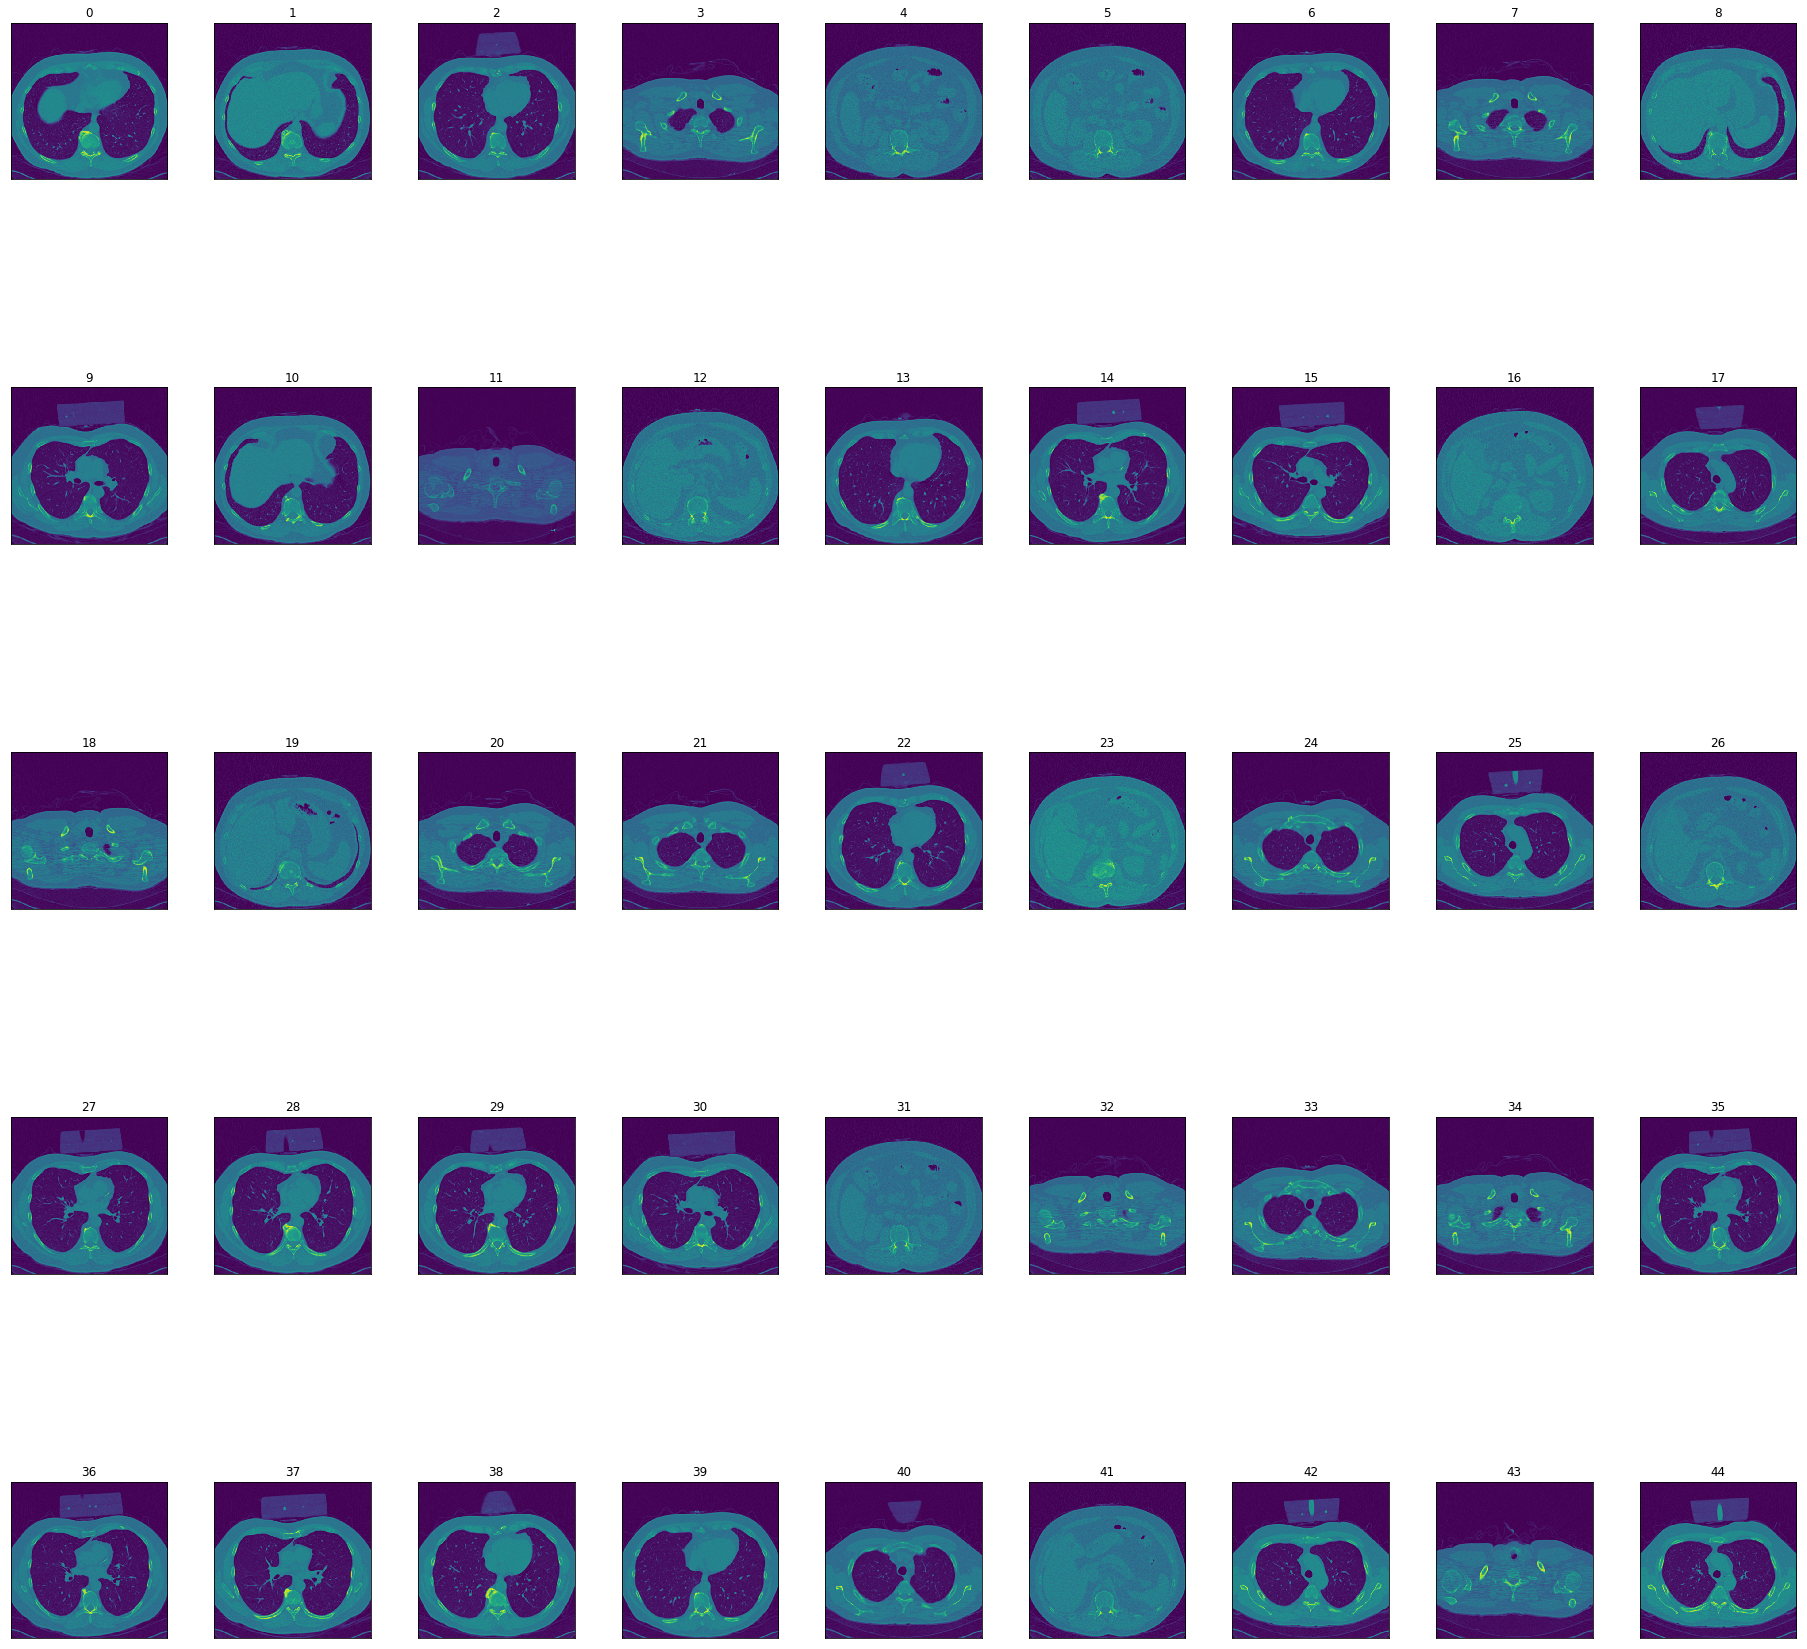

In [5]:
fig_rows = 5
fig_cols = 9
fig, axes = plt.subplots(fig_rows, fig_cols, figsize=(32, 32),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i,ax in enumerate(axes.flat):
    ax.imshow(labeless_data[i])
    ax.set_title(str(i))
plt.savefig('readme_images/image_vis.png')
plt.show()

### Visualization of Data

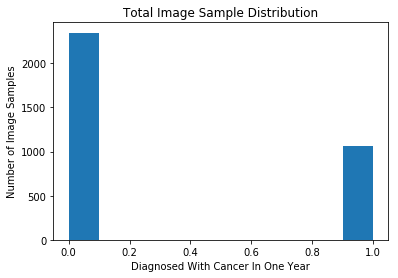

In [6]:
plotting_labels = [bool(x) for x in data_labels]
plt.hist(plotting_labels)
plt.xlabel("Diagnosed With Cancer In One Year")
plt.ylabel("Number of Image Samples")
plt.title("Total Image Sample Distribution")
plt.show()

### Split into Test, Validation, and Training Sets

In [11]:
labeled_data, data_labels = shuffle(labeled_data, data_labels)

train_index = int(labeled_data.shape[0]*0.70)
valid_index = int(labeled_data.shape[0]*0.85)

train_data, train_labels = labeled_data[:train_index], data_labels[:train_index]
valid_data, valid_labels = labeled_data[train_index:valid_index], data_labels[train_index:valid_index]
test_data, test_labels = labeled_data[valid_index:], data_labels[valid_index:]

print("Training Shape: " + str(train_data.shape))
print("\t Training Cancer Ratio: " + str(np.sum(train_labels)/train_labels.shape[0]))
print("Validation Shape: " + str(valid_data.shape))
print("\t Validation Cancer Ratio: " + str(np.sum(valid_labels)/valid_labels.shape[0]))
print("Test Shape: " + str(test_data.shape))
print("\t Test Cancer Ratio: " + str(np.sum(test_labels)/test_labels.shape[0]))

Training Shape: (2385, 512, 512)
	 Training Cancer Ratio: 0.311111111111
Validation Shape: (511, 512, 512)
	 Validation Cancer Ratio: 0.326810176125
Test Shape: (512, 512, 512)
	 Test Cancer Ratio: 0.296875




## Preprocessing



In [16]:
def center_and_normalize(data):
    mu = np.mean(data)
    return (data-mu)/np.std(data) 

def rotate(image, angle, fill_val):
    rot_matrix = cv2.getRotationMatrix2D((image.shape[0]//2,image.shape[1]//2), angle, 1)
    return cv2.warpAffine(image, rot_matrix, dsize=(image.shape[0], image.shape[1]),
                          flags=cv2.INTER_LINEAR+cv2.WARP_FILL_OUTLIERS, borderValue=fill_val)

def rotate_data(images, labels, angles, fill_val):
    counter = images.shape[0]
    cancer_count = np.sum(labels)
    addons = cancer_count*4 + (labels.shape[0]-cancer_count)*2
    rotated_images = np.append(images,np.zeros([addons,images.shape[1],images.shape[2]]), axis=0)
    rotated_labels = []
    for i,img in enumerate(images):
        used_angles = angles
        if labels[i] == 1: used_angles = angles + [10,-10]
        for angle in used_angles:
            rotated_images[counter,:,:] = rotate(img,angle,fill_val)
            counter+=1
            rotated_labels.append(labels[i])
    labels = np.append(labels,rotated_labels,axis=0)
    return rotated_images, labels

def chop(image, img_size):
    limit = image.shape[0]//img_size
    chops = []
    for i in range(1,limit+1):
        for j in range(1,limit+1):
            chops.append(image[img_size*i-img_size:img_size*i,img_size*j-img_size:img_size*j])
    return chops

def chop_data(images, img_size):
    chopped_images = []
    print("Start Chopping")
    for i,img in enumerate(images):
        chopped_images.append(chop(img, img_size))
    print("End Chopping")
    return np.array(chopped_images, dtype=np.float32)

def one_hot_encode(labels, n_labels):
    encoded_labels = np.zeros((labels.shape[0], n_labels), dtype=np.float32)
    for i,label in enumerate(labels):
        encoded_labels[i,int(label)] = 1
    return encoded_labels

def preprocess(images, labels, angles=[-5,5], add_data=False):
    print("Start Initial Copies")
    images_copy = center_and_normalize(images)
    labels_copy = labels.copy()
    print("Finish Initial Copies")
    if add_data:
        fill_val = float(images_copy[0,0,0])
        print("Start Rotations")
        images_copy, labels_copy = rotate_data(images_copy, labels_copy, angles, fill_val)
        print("Finish Rotations")
    return images_copy, labels_copy


### Preprocessing Visualizations

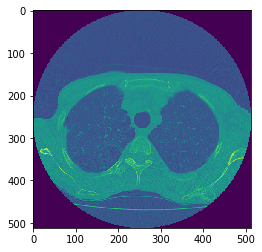

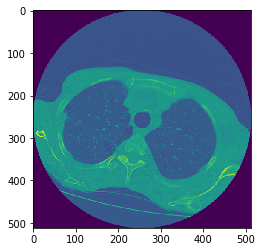

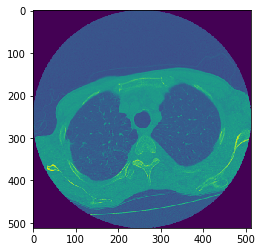

In [10]:
labeled_data[0:1] = center_and_normalize(labeled_data[0:1])
rot_images, rot_labels = rotate_data(labeled_data[0:1], data_labels[0:1], [-10,10], float(labeled_data[0,0,0]))
for img in rot_images:
    show_img(img)

Start Chopping
End Chopping
Unchopped Image


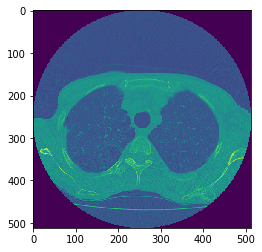


Image Chops


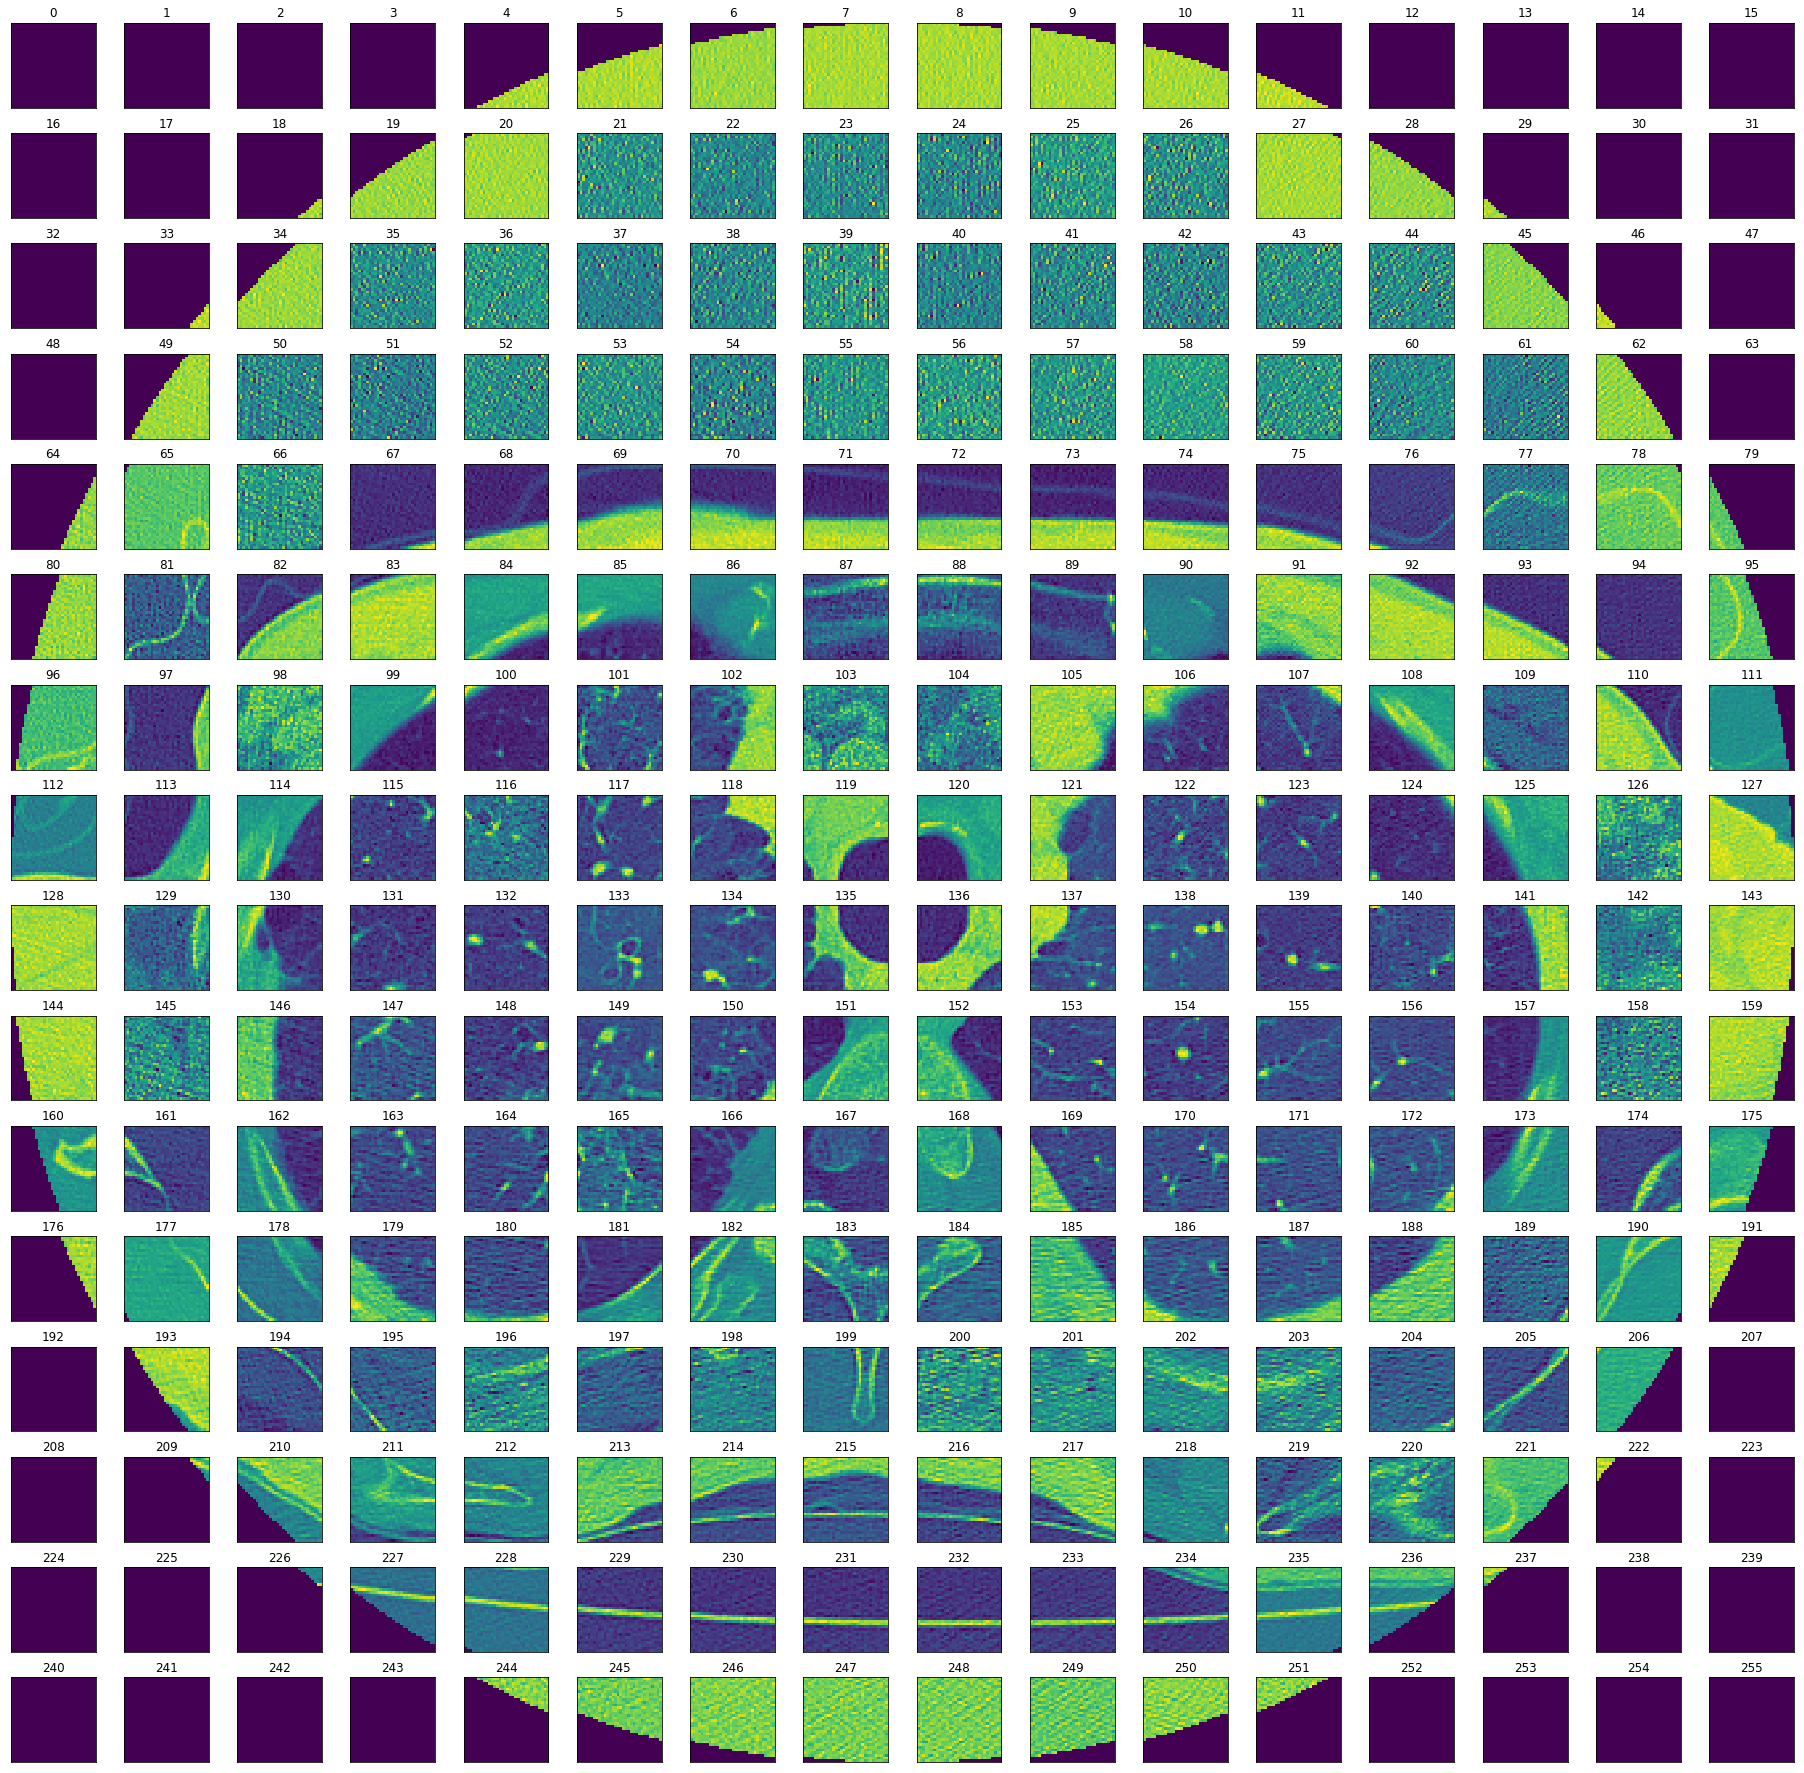

In [11]:
img_size = 32
chop_test = chop_data(rot_images,img_size)[0]

print("Unchopped Image")
show_img(rot_images[0])
print("\nImage Chops")

fig, axes = plt.subplots(16, 16, figsize=(32, 32),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i,ax in enumerate(axes.flat):
    ax.imshow(chop_test[i])
    ax.set_title(str(i))
plt.savefig('readme_images/chops_vis.png')
plt.show()

Start Initial Copies
Finish Initial Copies
Start Rotations
Finish Rotations
Start Chopping
End Chopping
Start Initial Copies
Finish Initial Copies
Start Chopping
End Chopping


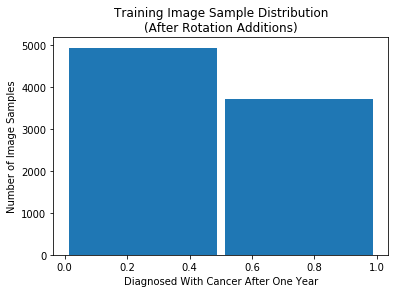

In [17]:
train_data, train_labels = preprocess(train_data, train_labels, add_data=True)
train_chops = chop_data(train_data, 32)
valid_data, valid_labels = preprocess(valid_data, valid_labels)
valid_chops = chop_data(valid_data, 32)

plt.hist(train_labels, bins=2, rwidth=.95)
plt.xlabel("Diagnosed With Cancer After One Year")
plt.ylabel("Number of Image Samples")
plt.title("Training Image Sample Distribution\n(After Rotation Additions)")
plt.show()

In [18]:
print(train_chops.shape)

(8639, 256, 32, 32)


In [19]:
train_chops = train_chops.reshape([t_shape for t_shape in train_chops.shape]+[1])
valid_chops = valid_chops.reshape([v_shape for v_shape in valid_chops.shape]+[1])
train_labels = one_hot_encode(train_labels,2)
valid_labels = one_hot_encode(valid_labels,2)


In [20]:
print(train_chops.shape)

(8639, 256, 32, 32, 1)



## Tensorflow Approach

#### Parameter Initializations

In [23]:
mu = 0
dev = 0.1

convweight_shapes = [

    (5,5,1,32), # 508
    # Pool: 127x127
    (4,4,32,8), # 124x124
    # Pool: 31x31
    (4,4,8,4) #28x28
    # Pool: 14x14
    
#     # Pool: 256x256
#     (75,75,1,8), # 182x182
#     # Pool: 91x91
#     (6,6,8,16), # 86x86
#     # Pool: 43x43
#     (4,4,16,8) # 40x40
#     # Pool: 20x20
]
fcweight_shapes = [
#     (20*20*8+28*28*8, 120),
    (14*14*4, 100),
    (100,2)
]

convweights = [tf.Variable(tf.truncated_normal(shape=x,mean=mu,stddev=dev)) for x in convweight_shapes]
convbiases = [tf.Variable(tf.zeros([x[-1]])) for x in convweight_shapes]

fcweights = [tf.Variable(tf.truncated_normal(shape=x,mean=mu,stddev=dev)) for x in fcweight_shapes]
fcbiases = [tf.Variable(tf.zeros([x[-1]])) for x in fcweight_shapes]


In [21]:
## Chopped Images Parameter Creation

mu = 0
dev = 0.1

chopped_convweight_shapes = [
    # 32x32
    (5,5,1,64), # 28x28
    # Pool: 14x14
    (5,5,64,16), # 10x10
    # Pool: 5x5
]
chopped_fcweight_shapes = [
    (5*5*16,50),
    (50,2),
    (2,1)
]

chopped_convweights = [tf.Variable(tf.truncated_normal(shape=x,mean=mu,stddev=dev),name="conv"+str(x[-1])) for x in chopped_convweight_shapes]
chopped_convbiases = [tf.Variable(tf.zeros([x[-1]]),name="convbias"+str(x[-1])) for x in chopped_convweight_shapes]

chopped_fcweights = [tf.Variable(tf.truncated_normal(shape=x,mean=mu,stddev=dev),name="fc"+str(x[-1])) for x in chopped_fcweight_shapes]
chopped_fcbiases = [tf.Variable(tf.zeros([x[-1]]),name="fcbias"+str(x[-1])) for x in chopped_fcweight_shapes]

combine_chops_weight = tf.Variable(tf.truncated_normal(shape=(((train_data.shape[1]//32)**2), 2), mean=mu, stddev=dev),name="combine")
combine_chops_bias = tf.Variable(tf.zeros([2]),name="combinebias")




In [24]:
def param_count(weight_shapes):
    total = 0
    for shape in weight_shapes:
        params = 1
        for dim in shape:
            params *= dim
        total += params + shape[-1]
    return total

print("Parameter Counts")
print("Main: " + str(param_count(convweight_shapes) + param_count(fcweight_shapes)) + "\n")
print("Chops: " + str(param_count(chopped_convweight_shapes)+param_count(chopped_fcweight_shapes)) + "\n")

Parameter Counts
Main: 84154

Chops: 47435




#### Neural Net Helper Functions

In [25]:
## Non Chopped Datas

def conv2d(data, weight, bias, stride=1, padding="VALID"):
    activations = tf.nn.bias_add(tf.nn.conv2d(data, weight,strides=[1,stride,stride,1],padding=padding),bias)
    return tf.nn.elu(activations)

def max_pool(data,k=2):
    return tf.nn.max_pool(data,ksize=[1,k,k,1],strides=[1,k,k,1],padding="VALID")

def conv_net(data, weights, biases, dropout_prob):
    logits = data
    for i,weight in enumerate(weights):
        logits = conv2d(logits, weight, biases[i])
        logits = max_pool(logits)
#         logits = tf.nn.dropout(logits, dropout_prob)
    return logits

def fc_net(data, weights, biases, dropout_prob):
    logits = data
    for i,weight in enumerate(weights):
        if i < len(weights)-1:
            logits = tf.matmul(logits, weight) + biases[i]
            logits = tf.nn.elu(logits)
    #         logits = tf.nn.dropout(logits, dropout_prob)
    return tf.matmul(logits,weights[-1])+biases[-1]

In [26]:
# data_features = tf.placeholder(tf.float32, [None, train_data.shape[1], train_data.shape[2], 1], name="data_features")
data_labels = tf.placeholder(tf.float32, [None, 2], name='data_labels')

convdropout = tf.placeholder(tf.float32, name="convdropout")
fcdropout = tf.placeholder(tf.float32, name="fcdropout")
momentum = tf.placeholder(tf.float32, name="momentum")
learning_rate = tf.placeholder(tf.float32, name="learning_rate")

# logits = conv_net(data_features,convweights,convbiases,convdropout)
# logits = tf.reshape(logits, [-1,fcweights[0].get_shape().as_list()[0]])
# logits = tf.nn.dropout(logits,convdropout)
# logits = fc_net(logits, fcweights, fcbiases, fcdropout)

# cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=data_labels))
# optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=momentum).minimize(cost)

# equals_list = tf.equal(tf.argmax(logits,1), tf.argmax(data_labels,1))
# accuracy = tf.reduce_mean(tf.cast(equals_list,tf.float32))

# save_file = './net.ckpt'
# saver = tf.train.Saver()

# init = tf.global_variables_initializer()


In [28]:
## Chopped Datas

batch_size = 100

def chopped_net(datas, conv_weights, conv_biases, fc_weights, fc_biases, batch_size, dropout_prob):
    combined_logits = []
    for i in range(batch_size):
        logits = conv_net(datas[i],conv_weights,conv_biases,dropout_prob)
        logits = tf.reshape(logits, [256,fc_weights[0].get_shape().as_list()[0]])
        logits = tf.nn.dropout(logits,dropout_prob)
        logits = fc_net(logits, fc_weights, fc_biases,dropout_prob)
        combined_logits.append(tf.reshape(logits,[256]))
    outputs = tf.stack(combined_logits)
    return outputs

def combine_chopped_logits(combined_logits, weight, bias):
    return tf.matmul(combined_logits, weight) + bias

In [29]:
c_shape = [shape for shape in train_chops.shape]
chopped_features = tf.placeholder(tf.float32, [None,c_shape[1],c_shape[2],c_shape[3],c_shape[4]], name="chopped_features")

chopped_logits = chopped_net(chopped_features, chopped_convweights, chopped_convbiases, chopped_fcweights, chopped_fcbiases, batch_size, convdropout)
combined_logits = combine_chopped_logits(chopped_logits, combine_chops_weight, combine_chops_bias)

chopped_cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=combined_logits,labels=data_labels))
chopped_optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=momentum).minimize(chopped_cost)

chopped_equals_list = tf.equal(tf.argmax(combined_logits,1), tf.argmax(data_labels,1))
chopped_accuracy = tf.reduce_mean(tf.cast(chopped_equals_list,tf.float32))

save_file = './net.ckpt'
saver = tf.train.Saver()

init = tf.global_variables_initializer()




#### Forward Pass and Training

In [30]:
## Helper Functions

def stop_early(loss,threshold):
    if len(loss) > 5:
        diffs = [loss[-i-1]-loss[-i] for i in range(5,0,-1)]
        if sum(diffs)/len(diffs) < threshold:
            return True
    return False

## Used to track hyperparameter experimentation
def write_to_file(file_name, weight_shapes, loss, rate, moment, epochs, batch_size, dropout_prob, acc):
    with open(file_name, 'a') as file:
        file.write("\nWeight shapes: \n")
        for weight in weight_shapes:
            file.write(str(weight) + str('\n'))
        file.write('Learning Rate: ' + str(rate) + '\n')
        file.write('Momentum: ' + str(moment) + '\n')
        file.write('Epoch Count: ' + str(epochs) + '\n')
        file.write('Batch size: ' + str(batch_size) + '\n')
        file.write("Dropout Probability: " + str(dropout_prob) + '\n')
        file.write('Loss: ' + str(loss) + '\n')
        file.write('Final Accuracy: ' + str(acc) + '\n\n')

In [31]:
rate = .05
moment = .75
conv_dropout = .5
fc_dropout = .5
epochs = 10

with tf.Session() as sess:
    sess.run(init)
    print("Session Start")
    n_batches = int(train_chops.shape[0]/batch_size)
    loss = []
    for epoch in range(epochs):
        train_chops, train_labels = shuffle(train_chops, train_labels)
        running_cost = 0
        for batch in range(1,n_batches):
            batch_x = train_chops[batch*batch_size-batch_size:batch*batch_size]
            batch_y = train_labels[batch*batch_size-batch_size:batch*batch_size]
            feed = {learning_rate: rate, momentum: moment,\
                                           convdropout: conv_dropout, fcdropout:fc_dropout,\
                                            chopped_features: batch_x, data_labels: batch_y}
            optcost = sess.run([chopped_optimizer, chopped_cost, chopped_accuracy], feed_dict=feed)
            running_cost += optcost[1]
            if batch % 10 == 0:
                print("Non-Cancer Percentage: " + str(1-np.sum(np.argmax(batch_y,1))/batch_size))
                print("Running Cost (Batch " + str(batch) + "): " + str(running_cost) + ", Acc: " + str(optcost[2]))
        loss.append(running_cost)
        print("Epoch: " + str(epoch+1))
        print("Training Cost: " + str(running_cost))
        valid_chops, valid_labels = shuffle(valid_chops, valid_labels)
        validation = {convdropout: 1.,fcdropout:1., chopped_features: valid_chops[:batch_size], data_labels: valid_labels[:batch_size]}
        accost = sess.run([chopped_accuracy,chopped_cost], feed_dict=validation)
        print("Actual Cancer Percentage: " + str(np.sum(np.argmax(valid_labels[:batch_size],1))/batch_size))
        print("Cost: " + str(accost[1]) + ", Accuracy: " + str(accost[0]))
    saver.save(sess,save_file)
    n_batches = int(valid_chops.shape[0]/batch_size)
    running_acc = 0
    for batch in range(n_batches):
        batch_x = valid_chops[batch*batch_size-batch_size:batch*batch_size]
        batch_y = valid_labels[batch*batch_size-batch_size:batch*batch_size]
        feed = {learning_rate: rate, momentum: moment,\
                                       convdropout: 1., fcdropout: 1.,\
                                        chopped_features: batch_x, data_labels: batch_y}
        acc = sess.run(chopped_accuracy, feed_dict=feed)
        running_acc += acc
    print("Validation Accuracy: " + str(running_acc/n_batches))

    plt.plot(np.arange(len(loss)), loss)
    plt.ylim([0,loss[0]])
    plt.title("Loss Over Training Epochs")
    plt.show()
        

Session Start
Non-Cancer Percentage: 0.57
Running Cost (Batch 10): 6.88704007864, Acc: 0.57
Non-Cancer Percentage: 0.48
Running Cost (Batch 20): 13.5690802932, Acc: 0.72
Non-Cancer Percentage: 0.55
Running Cost (Batch 30): 19.4605230689, Acc: 0.68
Non-Cancer Percentage: 0.55
Running Cost (Batch 40): 24.548532337, Acc: 0.72
Non-Cancer Percentage: 0.6
Running Cost (Batch 50): 28.4355395734, Acc: 0.89
Non-Cancer Percentage: 0.56
Running Cost (Batch 60): 31.8649598062, Acc: 0.88
Non-Cancer Percentage: 0.55
Running Cost (Batch 70): 34.8641291261, Acc: 0.86
Non-Cancer Percentage: 0.59
Running Cost (Batch 80): 37.5946577787, Acc: 0.94
Epoch: 1
Training Cost: 38.8455337286
Actual Cancer Percentage: 0.41
Cost: 0.228534, Accuracy: 0.94
Non-Cancer Percentage: 0.49
Running Cost (Batch 10): 2.07207588106, Acc: 0.95
Non-Cancer Percentage: 0.5
Running Cost (Batch 20): 4.46550422162, Acc: 0.95
Non-Cancer Percentage: 0.54
Running Cost (Batch 30): 5.8119654581, Acc: 0.98
Non-Cancer Percentage: 0.57
Runn

KeyboardInterrupt: 


## Session



## Results
